In [1]:
%load_ext autoreload
%autoreload 2

import os
import oddsapi
import requests
import pandas as pd
import numpy as np
from common.utils.odds_utils import get_tournament_winner_odds, get_group_stage_odds
API_KEY = os.getenv("API_KEY")
from oddsapi import OddsApiClient
client = OddsApiClient(api_key=API_KEY)
from common.utils.simulation_utils import WorldCupTeam, WorldCupSim
# client.retrieve_sports()

In [2]:
df_winner = get_tournament_winner_odds(API_KEY)
df_group_stage = get_group_stage_odds(API_KEY)
df_groups = pd.read_csv("common/ressources/df_groups.csv")[["Team","group"]]
df_group_stage = df_group_stage[['home_team','away_team','prob1','probx', 'prob2']].merge(df_groups.rename(columns =  {"Team":"home_team"}), on = "home_team")

In [57]:
import copy as copy
Nsims = 1000
sims = []
for _ in range(Nsims):
    # collect team data (needs to be redone in each loop of sim)
    group_names = list(df_groups["group"].unique())
    teams = [WorldCupTeam(row['group'], row['Team']) for ix, row in df_groups.iterrows()]
        # initialise simulation
    s = WorldCupSim(group_names, teams, df_group_stage, df_winner, verbose=False)
    
    # run simulated world cup
    s.runsim() 
    sims.append(copy.deepcopy(s))

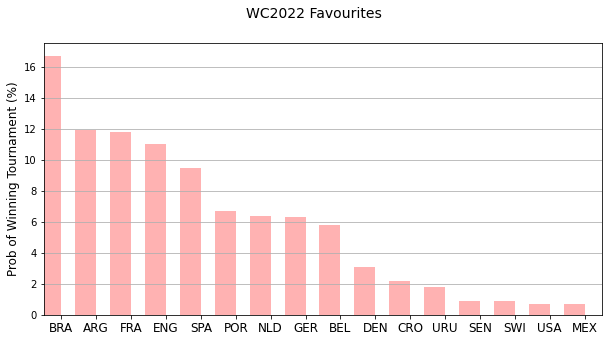

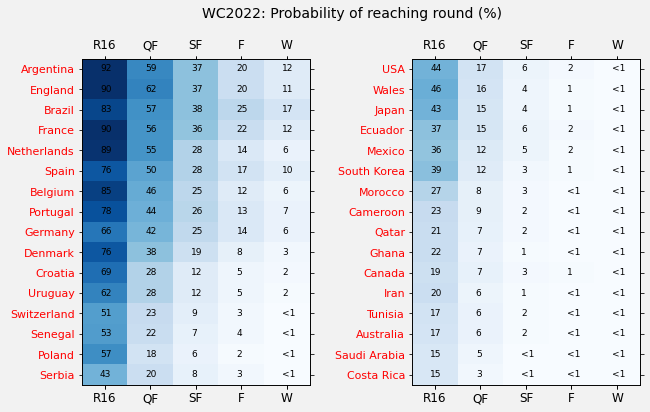

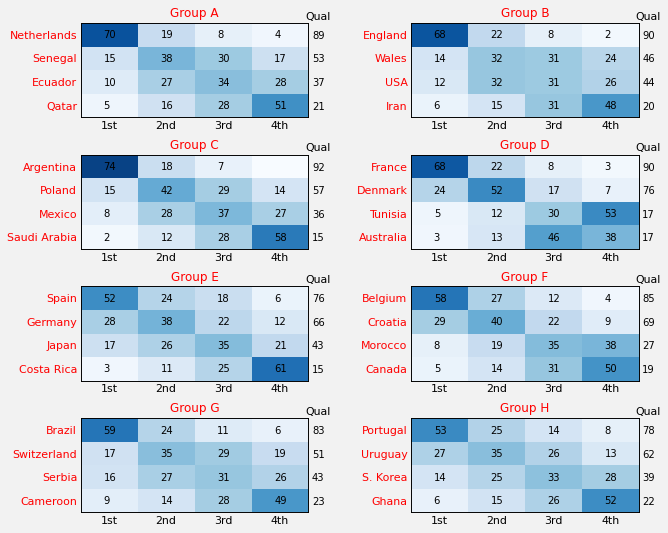

In [58]:
from common.utils.WorldCupMetrics import SimWinners, makeProgressPlot, ExpectedGroupFinishesPlot, make_sankey
savePlots = True # plots saved in same directory
teamnames = list( df_groups["Team"].values )
SimWinners(sims,teamnames,includeOdds=False, save=savePlots)
makeProgressPlot( sims, teamnames, save=savePlots )
ExpectedGroupFinishesPlot(sims,group_names, save=savePlots)
make_sankey("Denmark", sims)

In [60]:
make_sankey("Denmark", sims)

In [59]:
import pandas as pd
import plotly
import plotly.graph_objs as go


def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#4F9119','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

def make_sankey(teamname, sims):
# trace probability of a team progressing through the tournament
    Nsims = float(len(sims))
    stages = ['GRP','R16','QF','SF','Final','Winner']
    group_stages = list(np.full(int(Nsims),"Group D"))
    R16_opponents = list(np.full(int(Nsims),"null"))
    QF_opponents = list(np.full(int(Nsims),"null"))
    SF_opponents = list(np.full(int(Nsims),"null"))
    Final_opponents = list(np.full(int(Nsims),"null"))
    count = 0
    for count, s in enumerate(sims):
        for i in range(len(s.KnockOut.R16matches)):
            if teamname==s.KnockOut.R16matches[i].team1.name: 
                R16_opponents[count] = s.KnockOut.R16matches[i].team2.name + " - R16"
            elif teamname==s.KnockOut.R16matches[i].team2.name: 
                R16_opponents[count] = s.KnockOut.R16matches[i].team1.name + " - R16"
        
        for i in range(len(s.KnockOut.QFmatches)):
            if teamname==s.KnockOut.QFmatches[i].team1.name: 
                QF_opponents[count] = s.KnockOut.QFmatches[i].team2.name + " - QF"
            elif teamname==s.KnockOut.QFmatches[i].team2.name: 
                QF_opponents[count] = s.KnockOut.QFmatches[i].team1.name + " - QF"
                
        for i in range(len(s.KnockOut.SFmatches)):
            if teamname==s.KnockOut.SFmatches[i].team1.name: 
                SF_opponents[count] = s.KnockOut.SFmatches[i].team2.name + " - SF"
            elif teamname==s.KnockOut.SFmatches[i].team2.name: 
                SF_opponents[count] = s.KnockOut.SFmatches[i].team1.name + " - SF"
        
        for i in range(len(s.KnockOut.Final)):
            if teamname==s.KnockOut.Final[i].team1.name: 
                Final_opponents[count] = s.KnockOut.Final[i].team2.name + " - Final"
            elif teamname==s.KnockOut.Final[i].team2.name: 
                Final_opponents[count] = s.KnockOut.Final[i].team1.name + " - Final"
                
        count += 1 

    df_finals = pd.concat([pd.Series(group_stages),
                        pd.Series(R16_opponents),
                        pd.Series(QF_opponents),
                        pd.Series(SF_opponents),
                        pd.Series(Final_opponents)], axis = 1)

    df_finals.columns = ["Group","R16", "QF", "SF", "Final"]
    df_finals["count"] = 0
    df_finals = df_finals.groupby(["Group","R16", "QF", "SF", "Final"], sort=False).size().reset_index(name='count')
    df_finals[["QF", "SF", "Final"]] = df_finals[["QF", "SF", "Final"]].replace('null', np.nan)
    df_finals["R16"] = df_finals["R16"].replace('null', "Not in playoffs")
    
    fig = genSankey(df_finals, cat_cols = ["Group","R16", "QF", "SF", "Final"], value_cols = "count", title = "Denmarks road to the final")
    plotly.offline.plot(fig, validate=False)

In [56]:
import pandas as pd
import plotly
import plotly.graph_objs as go
fig = genSankey(df_finals, cat_cols = ["Group","R16", "QF", "SF", "Final"], value_cols = "count", title = "Denmarks road to the final")
plotly.offline.plot(fig, validate=False)

'temp-plot.html'

In [46]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#4F9119','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [11]:
Table

{'France': array([676., 226.,  80.,  18.]),
 'Denmark': array([254., 481., 195.,  70.]),
 'Australia': array([ 29., 141., 421., 409.]),
 'Tunisia': array([ 41., 152., 304., 503.])}